# Python Bootcamp Day 6
## Multi-dimensional data with xarray, part 2

# Challenge 

"The World Ocean Atlas (WOA) is a collection of objectively analyzed, quality controlled temperature, salinity, oxygen, phosphate, silicate, and nitrate means based on profile data from the World Ocean Database (WOD). It can be used to create boundary and/or initial conditions for a variety of ocean models, verify numerical simulations of the ocean, and corroborate satellite data." - [NOAA National Centers for Environmental Information](https://www.ncei.noaa.gov/products/world-ocean-atlas)

In this challenge, we will explore WOA temperature and oxygen climatologies. A climatology indicates the average environmental conditions over a long period of time, generally 30 years or more. Here, we are looking at annual means, so all seasonal variability has been removed. 

### Tasks: 

1) **Find Data** 
    * Starting from this website, navigate to the OPENDAP link for temperature and dissolved oxygen and open these datasets in your notebook using xarray.open_dataset(). https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/
    * Hint: Select 1 degree NetCDF output for "Averaged Decades Years", then select the annual file. (For the oxygen dataset, only one time period is available)
<br><br>
2) **Understand the Datasets**
    * Look through the netcdf metadata. Select the variables of interest.
    * You may find the dataset documentation useful: https://www.ncei.noaa.gov/sites/default/files/2020-04/woa18documentation.pdf
    * Note the different time periods for temperature and oxygen (1981-2010 vs. 1955-2010). This is not ideal, but we'll have to work with the data that is easily accessible. 
<br><br>
3) **Merge Temperature and Oxygen into one dataset**
    * Hint: https://docs.xarray.dev/en/latest/generated/xarray.Dataset.merge.html
<br><br>
4) **Select surface-level values**

5) **Make maps of temperature and oxygen annual mean climatologies**

6) **Calculate correlation between temperature datasets**
    * Import the mean SST netcdf that we exported earlier
    * Calculate the Pearson correlation coefficient between the two temperature datasets
    * Hint: https://docs.xarray.dev/en/stable/generated/xarray.corr.html?highlight=corr
    * How well do the climatologies match up?
<br><br>
7) **Calculate correlation between WOA temperature and oxygen**
    * First, make a scatter plot of temperature vs. oxygen. Does this relationship make sense based on our knowledge of chemistry?
    * Calculate the Pearson correlation coefficient
<br><br>
8) **Calculate the line of best fit**
    * Hint: 

        ```
        # Import stats module
        from scipy import stats
        # Create 1-D numpy arrays
        x = woa_data_surface.t_an.to_numpy().flatten()
        y = woa_data_surface.o_an.to_numpy().flatten()
        # Remove np.nan values by masking
        mask = ~np.isnan(x) & ~np.isnan(y)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
        ```
<br>
9) **Add the line of best fit to your scatter plot**

10) **Visualize spatially**
    * While most points sit close to the line of best fit, we see some points where our expected oxygen does not match what we observe. Why might this be the case? To investigate, let's plot these points spatially so that we can see if spatial patterns emerge. 
    * Use the line of best fit, to calculate the 'expected_o2', and add this as a new variable in your dataset. This is the oxygen concentration that we would estimate based on temperature measurements alone.
    * Now, calculate the difference between the 'expected_o2' and the measured value. 
    * Plot this difference on a map. What spatial trends do you observe? Any ideas about why the observed oxygen differs from the expected value in these regions?

**Everything below is the solution and should be deleted in the student notebook**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Import xarray 
import xarray as xr

## Import Temperature data

In [3]:
path = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/temperature/decav/1.00/woa18_decav_t00_01.nc'
woa_temp = xr.open_dataset(path, decode_times=False)

In [ ]:
woa_temp

In [4]:
woa_temp = woa_temp.t_an

## Import oxygen data

In [5]:
path = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/oxygen/all/1.00/woa18_all_o00_01.nc'
woa_oxygen = xr.open_dataset(path, decode_times=False)

In [ ]:
woa_oxygen

In [6]:
woa_oxygen = woa_oxygen.o_an

In [7]:
woa_data = xr.merge([woa_temp, woa_oxygen])

In [8]:
woa_data_surface = woa_data.sel(depth=0).mean(dim='time')

## Plot surface-level data

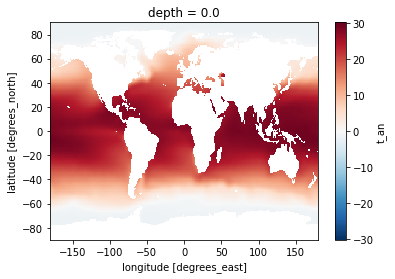

In [9]:
woa_data_surface.t_an.plot()

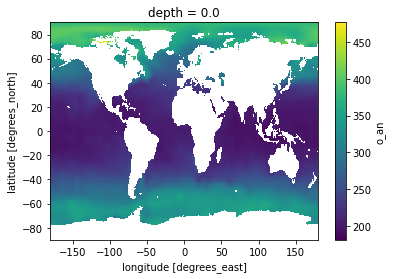

In [10]:
woa_data_surface.o_an.plot()

## Correlation between datasets

Compare the WOA climatology to the ERA5 hindcast

In [12]:
sst_climatology_era5 = xr.open_dataset('sst_climatology_era5.nc')

In [14]:
xr.corr(woa_data_surface.t_an, sst_climatology_era5.temp, dim=None)

<xarray.DataArray ()>
array(0.99975833)

## Correlation between variables

Text(0.5, 0, 'Oxygen Concentration [umol/kg]')

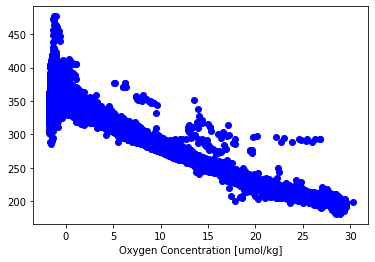

In [15]:
plt.plot(woa_data_surface.t_an, woa_data_surface.o_an, 'o', color='blue');
plt.xlabel('Temperature [C]')
plt.xlabel('Oxygen Concentration [umol/kg]')

In [16]:
xr.corr(woa_data_surface.t_an, woa_data_surface.o_an, dim=None)

<xarray.DataArray ()>
array(-0.97640911)
Coordinates:
    depth    float32 0.0

In [17]:
# Calculate line of best fit
# Provide some clues here

x = woa_data_surface.t_an.to_numpy().flatten()
y = woa_data_surface.o_an.to_numpy().flatten()

mask = ~np.isnan(x) & ~np.isnan(y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])

print(slope, intercept, r_value, p_value, std_err)

-5.522397766566795 346.63359056842626 -0.9764090999023465 0.0 0.006025035549081047


In [18]:
woa_data_surface['expected_o2'] = slope*(woa_data_surface.t_an) + intercept

Text(0.5, 0, 'Oxygen Concentration [umol/kg]')

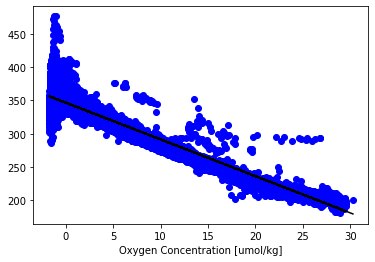

In [19]:
# Plot line on scatter plot
plt.plot(woa_data_surface.t_an, woa_data_surface.o_an, 'o', color='blue');
plt.plot(woa_data_surface.t_an, woa_data_surface['expected_o2'], color='k')
plt.xlabel('Temperature [C]')
plt.xlabel('Oxygen Concentration [umol/kg]')

### Visualize spatially

In [20]:
woa_data_surface['o2_anomaly'] = woa_data_surface['expected_o2'] - woa_data_surface['o_an']

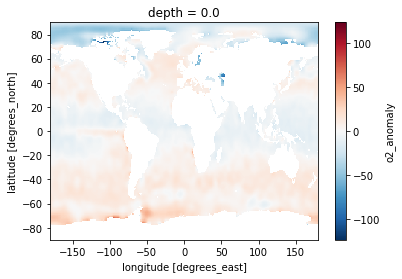

In [21]:
woa_data_surface.o2_anomaly.plot()